In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../LaurieOnTracking')
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_PitchControl as mpc
import Metrica_Velocities as mvel

from itertools import groupby
import ast

In [2]:
result_matches = [] 

In [3]:
matches = ['metrica_1', 'metrica_2']
match = 'metrica_1'

In [4]:
# load event data from Metrica always to use reverse function
DATADIR = '../sample-data-master/data'
game_id = 1 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)
if (match == 'metrica_1') or (match == 'metrica_2'):
    if match == 'metrica_1':
        game_id = 1 # let's look at sample match 1
    elif match == 'metrica_2':
        game_id = 2

    # read in the event data
    events = mio.read_event_data(DATADIR,game_id)

    # Bit of housekeeping: unit conversion from metric data units to meters
    events = mio.to_metric_coordinates(events)
    events.head()
    #### TRACKING DATA ####

    # READING IN TRACKING DATA
    tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
    tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

    # Convert positions from metrica units to meters 
    tracking_home = mio.to_metric_coordinates(tracking_home)
    tracking_away = mio.to_metric_coordinates(tracking_away)
    # reverse direction of play in the second half so that home team is always attacking from right->left
    tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)
    if match=='metrica_1':
        tracking_home, tracking_away, events= mio.change_playing_direction_both(tracking_home, tracking_away, events)
    #query features
    query_features = pd.read_csv('.././results' + '/metrica_' + str(game_id) +
                                     '_query_features.csv', sep=";")
    

Reading team: home
Reading team: away


In [5]:
# ball laying still--> set piece or outside
#when zero ball velocity or nan --> "Out"
query_features['close to ball'] = np.where((pd.isnull(query_features['ball velocity'])) |(query_features['ball velocity']== 0) | (pd.isnull(query_features['close to ball']))
                                           , "Out", query_features['close to ball'])
#
event = query_features['close to ball']
values = [event, event.shift(-1), event.shift(-2), event.shift(-3), event.shift(-4), event.shift(-5)]
sequence = np.all([v == values[0] for v in values], axis=0)
#[event[x]= np.where(sequence[x], event[x], event[x-1]) for x in range(1, len(event))]
possession = []
value = 'Out'
# loop through possession, is 5 in a row change,
for x in range(len(event)):
    if sequence[x]:
        value = event.iloc[x]
    elif value == 'Out': #changes when ball out or set piece
        value=event.iloc[x]
    possession.append(value)
    
query_features['possession'] = possession
#query_features = query_features.drop(columns=['closest to ball_home', 'closest to ball_away', 'close to ball'])

In [6]:
# ball possession
query_features['phase'] = (query_features['possession'] != query_features['possession'].shift(1)).fillna(0).cumsum(skipna=False)
phases = query_features.groupby('phase').agg(
        Condition=('possession', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last')
        )

In [7]:
query_features.reset_index()
query_features.index +=1
query_features.head(10)

,frame,ball x,ball y,ball velocity,inside,zone,centroid x_home,centroid y_home,centroid_zone_home,rest defence_home,...,centroid y_away,centroid_zone_away,rest defence_away,width_away,length_away,occupancy map_away,team distance_away,close to ball,possession,phase
1,1,-4.210850,-7.976468,NaN,True,8.0,10.094571,-5.163961,11.0,9.0,...,-1.267493,8.0,5.0,60.867956,31.771274,"[0, 1, 0, 0, 2, 4, 1, 2]",9.028938,Out,Out,1
2,11,-7.553878,-17.627436,28.560805,True,9.0,10.047931,-6.105054,11.0,10.0,...,-1.857080,8.0,3.0,61.266504,32.389466,"[0, 0, 0, 1, 3, 6, 0, 0]",10.760712,Away,Away,2
3,21,-7.182348,-20.427676,2.905701,True,9.0,10.163927,-7.137878,11.0,10.0,...,-2.569088,8.0,2.0,61.505456,33.046666,"[1, 0, 0, 0, 3, 6, 0, 0]",10.939565,Away,Away,2
4,31,-6.145138,-20.814868,2.765478,True,9.0,10.325661,-8.100731,11.0,10.0,...,-3.244396,8.0,3.0,61.649412,33.450950,"[1, 0, 0, 0, 3, 6, 0, 0]",10.681626,Away,Away,2
5,41,-4.389248,-20.411492,2.537699,True,9.0,10.513568,-8.882724,11.0,10.0,...,-3.826360,11.0,4.0,61.650500,33.563098,"[0, 0, 1, 0, 3, 6, 0, 0]",9.918641,Away,Away,2
6,51,1.426230,-16.040588,20.190681,True,12.0,10.687895,-9.395410,11.0,8.0,...,-4.240868,11.0,5.0,61.494848,33.277428,"[1, 0, 1, 0, 1, 5, 1, 1]",8.839663,Out,Away,2
7,61,5.179584,-13.019212,20.190681,True,12.0,10.807898,-9.567083,11.0,8.0,...,-4.435932,11.0,6.0,61.229512,32.544226,"[0, 1, 0, 0, 1, 5, 2, 1]",8.296240,Away,Away,2
8,71,4.942462,-12.285152,1.199442,True,12.0,10.849757,-9.377771,11.0,8.0,...,-4.366783,11.0,5.0,60.832120,31.559168,"[0, 1, 0, 1, 1, 4, 2, 1]",8.035096,Away,Away,2
9,81,3.466730,-7.746288,14.779685,True,11.0,10.857654,-8.845392,11.0,8.0,...,-4.019970,11.0,5.0,60.324908,30.543794,"[0, 1, 0, 1, 2, 3, 1, 2]",8.537391,Home,Away,2
10,91,1.807194,-2.583728,14.779685,True,11.0,10.904093,-8.020688,11.0,8.0,...,-3.428302,11.0,5.0,59.681900,29.589158,"[0, 1, 1, 1, 2, 2, 1, 2]",9.867063,Away,Away,2


In [8]:
# goal gegenpressing
query=query_features.copy()
gegenpressing = []

conditionA = [(query['possession'] == 'Home') & (
    (query.zone == 1) | (query.zone == 2) | (query.zone == 3) |
    (query.zone == 4) | (query.zone == 5) | (query.zone == 6) | (query.zone == 7) | (query.zone == 8) |
    (query.zone == 9)) , 12]
conditionB = [(query['possession']== 'Away'), 12]
gegenpressing.append([conditionA, conditionB])#

conditionA = [(query['possession'] == 'Away') & (
    (query.zone == 10) | (query.zone ==11) |
    (query.zone == 12) | (query.zone == 13) | (query.zone == 14) | (query.zone == 15) |
    (query.zone == 16) | (query.zone == 17) | (query.zone == 18)) , 12]
conditionB = [(query['possession']== 'Home'), 12]

gegenpressing.append([conditionA, conditionB])#

# transition
# speed
# pass cuts out number of defenders
# end in zone 14 or 17

In [9]:
def find_intervals(query_interval, condition, extra_time):
    """
    Method to find intervals that meet the condition
    
    params:
        query_interval: dataframe with feature values
        condition: list with true/false values for on query_interval for a certain condition
        extra:time: number of frames till the next condition

    returns:
        intervals: list with [start_frame, range()]
    """
    query_interval['cond'] = condition
    query_interval['phase'] = (query_interval['cond'] != query_interval['cond'].shift(1)).fillna(0).cumsum(skipna=False)
    phases= query_interval.groupby('phase').agg(
        Condition=('cond', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last')
        )
    phases = phases[phases.Condition]
    intervals = [[[], range(phases.Start_frame.iloc[x], phases.End_frame.iloc[x]+extra_time)] for x in range(len(phases))]
    return intervals




In [10]:
def find_intervals_custom(query_interval, condition, extra_time):
    """
    Method to find intervals that meet the condition
    
    params:
        query_interval: dataframe with feature values
        condition: list with true/false values for on query_interval for a certain condition
        extra:time: number of frames till the next condition

    returns:
        intervals: list with [start_frame, range()]
    """
    query_interval['cond'] = condition
    query_interval['phase'] = (query_interval['cond'] != query_interval['cond'].shift(1)).fillna(0).cumsum(skipna=False)
    # only first 5 seconds
    query_interval = query_interval.groupby('phase').head(13)
    phases= query_interval.groupby('phase').agg(
        Condition=('cond', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last'),
        centroid_x_start = ('centroid x_away', 'first'),
        centroid_x_end = ('centroid x_away', 'last'),
        centroid_y_start = ('centroid y_away', 'first'),
        centroid_y_end = ('centroid y_away', 'last'),

        )
    phases['x_move_net'] = (phases['centroid_x_end'] - phases['centroid_x_start']) / (phases['End_frame'] - phases['Start_frame'])
    phases = phases[(phases.Condition) & (phases['x_move_net'] > 0.03)]
    intervals = [[[], range(phases.Start_frame.iloc[x], phases.End_frame.iloc[x]+extra_time)] for x in range(len(phases))]

    return intervals


In [11]:
def check_conditions(query, conditions, framesize = 10):
    """
    Function to verify which conditions are indivually met
    
    params:
        query: Dataframe with feature items 
        conditions: listed with conditions in formation [["A", query.inside==False, int(sequence)], ...]
        framesize: the size of a frame, typically 10
    returns
        df query with additional column query that has letters for the conditions he meet
    """
    for condition in range(len(conditions)):
        if condition == 0:
                        query['query'] = np.where(conditions[condition][0], "L" + str(condition), "")
        else:
            query['query'] = query['query'] + np.where(conditions[condition][0], "L" + str(condition), "")

    return query

In [12]:
def find_intersections(intervals_combi, intervals_new):
    ''' Function to find which intervalt that intersect with each other
    
    params:
        intervals_combi: list with [[ranges[, range]
        intervals_new: list with [[ranges], range]
    returns:
        intersections: a list of ranges from intervalsB that intersect with intervalS
    ''' 
   
    intervalsA = [intervals_combi[x][1] for x in range(len(intervals_combi))]
    old_intervals = [intervals_combi[x][0] for x in range(len(intervals_combi))]
    intervalsB = [intervals_new[x][1] for x in range(len(intervals_new))]

    intersections= []
    
    i = j = 0
    valueA = np.nan
    valueB = np.nan
    while i < len(intervalsA) and j < len(intervalsB):
        # a before b, otherwise increase j
        if min(intervalsA[i]) > min(intervalsB[j]):
            j +=1
            continue
                  
        # Left bound for intersecting segment / biggest start          
        left = max(min(intervalsA[i]), min(intervalsB[j]))
        # Right bound / smallest end point
        right = min(max(intervalsA[i]), max(intervalsB[j]))
            
        if left <= right:
            # deal with two different intervals after for the same A
            if intervalsA[i] != valueA:
                old_interval = old_intervals[i]
                old_interval.append(intervalsA[i])
            if intervalsB[j] != valueB:
                intersections.append([old_interval, intervalsB[j]])
                valueA = intervalsA[i]
                valueB = intervalsB[j]
       
        # If i-th interval's right bound is  
        # smaller increment i else increment j 
        if max(intervalsA[i]) < max(intervalsB[j]):
            i += 1
        else:
            j += 1
        
    return intersections

In [13]:
def check_results(test, conditions):
    """ Functions that checks which episodes meet the conditions
    
    Params:
        test: DF with all features
        conditions: listed with conditions in formation [["A", query.inside==False], ...]
    returns:
        results: list with all episodes that meet the conditions
    """
    # Check conditions and put letter in query DF
    interval_combi = find_intervals(test, conditions[0][0], conditions[0][1])
    
    for num_cond in range(1, len(conditions)):
        if num_cond==1:
            interval = find_intervals_custom(test, conditions[num_cond][0], conditions[num_cond][1])
        else:
            interval = find_intervals(test, conditions[num_cond][0], conditions[num_cond][1]) 
        interval_combi = find_intersections(interval_combi, interval)

    return interval_combi
        

# get all results and make episode of it
new_results = []
#for corner in cornerQ:
for expression in gegenpressing:
    results = (check_results(query, expression))
    print(results)
    for item in results:
        try:
            start_time = min(item[0][0]) # item[0]
            end_time = max(item[1]) #- 51
            new_results.append(range(start_time-2*25, end_time+1*25))
        except: 
            continue


[[[range(30421, 30813)], range(30811, 30943)], [[range(43281, 43353)], range(43351, 43483)], [[range(47161, 47253)], range(47251, 47383)], [[range(54291, 54393)], range(54391, 54523)], [[range(54601, 55253)], range(55251, 55383)], [[range(57541, 57553)], range(57551, 57683)], [[range(64491, 64663)], range(64661, 64793)], [[range(72211, 72233)], range(72231, 72363)], [[range(93641, 93833)], range(93831, 93963)], [[range(103741, 104083)], range(104081, 104213)], [[range(105651, 105673)], range(105671, 105803)], [[range(116081, 116483)], range(116481, 116613)], [[range(132451, 132763)], range(132761, 132883)], [[range(140661, 140743)], range(140741, 140873)]]
[[[range(67791, 67953)], range(67951, 68083)], [[range(92651, 92673)], range(92671, 92803)], [[range(95871, 95963)], range(95961, 96093)], [[range(104151, 104253)], range(104251, 104383)], [[range(107981, 108023)], range(108021, 108153)]]


In [14]:
results

[[[range(67791, 67953)], range(67951, 68083)],
 [[range(92651, 92673)], range(92671, 92803)],
 [[range(95871, 95963)], range(95961, 96093)],
 [[range(104151, 104253)], range(104251, 104383)],
 [[range(107981, 108023)], range(108021, 108153)]]

In [15]:
new_results

[range(30371, 30967),
 range(43231, 43507),
 range(47111, 47407),
 range(54241, 54547),
 range(54551, 55407),
 range(57491, 57707),
 range(64441, 64817),
 range(72161, 72387),
 range(93591, 93987),
 range(103691, 104237),
 range(105601, 105827),
 range(116031, 116637),
 range(132401, 132907),
 range(140611, 140897),
 range(67741, 68107),
 range(92601, 92827),
 range(95821, 96117),
 range(104101, 104407),
 range(107931, 108177)]

In [16]:
STOP
DATADIR = '../../data_clean/results/gegenpressing/temporal/' + match + '/'
PLOTDIR = DATADIR
start_minute = 12
end_minute = 13

counter = 2
for result in new_results: 
    start_frame= min(result)  # - 5*25
    end_frame = max(result) #+ 15*25
    home = tracking_home[(tracking_home.index >=start_frame) & (tracking_home.index <= end_frame)]
    away = tracking_away[(tracking_away.index >=start_frame) & (tracking_away.index <= end_frame)]
    counter+=1
    mviz.save_match_clip(home, away,PLOTDIR,fname='gegen'+ str(counter), include_player_velocities=False)


NameError: name 'STOP' is not defined

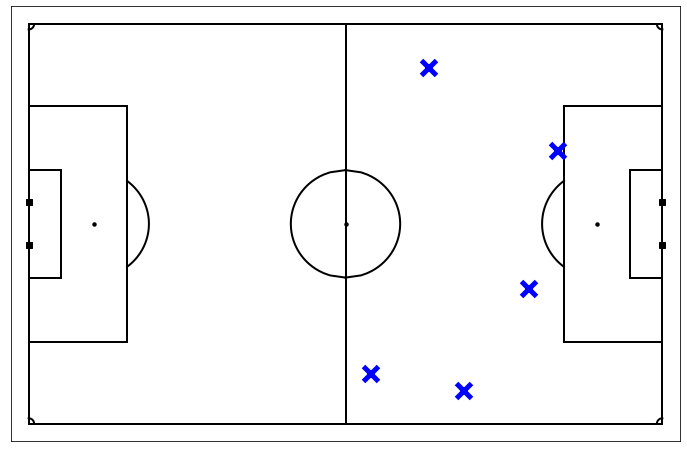

In [21]:
fig,ax = mviz.plot_pitch()
for range_result in results:
    loss = range_result[0][0]
    start = max(loss)
    #ax.plot(tracking_home[(tracking_home.index == start)]['ball_x'], \
    #        tracking_home[(tracking_home.index == start)]['ball_y'],'rd')
    
    #ax.plot(tracking_home[(tracking_home.index >= start) & (tracking_home.index <= end)]['ball_x'], \
    #        tracking_home[(tracking_home.index >= start) & (tracking_home.index <= end)]['ball_y'],'r')
    ax.plot(tracking_home[(tracking_home.index == start)]['ball_x'], \
            tracking_home[(tracking_home.index == start)]['ball_y'],'x', color='b', mew=5, ms=15)
    #ax.plot(tracking_home[(tracking_home.index == end)]['ball_x'], \
    #        tracking_home[(tracking_home.index == end)]['ball_y'],'ro')


#ax.plot(tracking_home['ball_x'].iloc[300],tracking_home['ball_y'].iloc[300],'ro')
#ax.plot(tracking_home['ball_x'].iloc[300:550+1],tracking_home['ball_y'].iloc[300:550+1],'r')

In [ ]:
results[0][0][0]